In [1]:
#Importar librerías
import pandas as pd
import os
import zipfile
import shutil
import requests
import zipfile
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from shapely.geometry import box

In [2]:
#Definir directorio de trabajo
#Directorio de trabajo. Si existe directorio D:/, se selecciona si no, C:/
try:
    os.chdir('C:/users/claud/Documents/GitHub/proyecto_infotec')
except:
    os.chdir('C:/users/claudio.pacheco/Documents/Github/proyecto_infotec')
#if os.path.exists('D:/'):
#    os.chdir('D:/github/proyecto_infotec')
#else:
#    os.chdir('C:/users/claudio.pacheco/Documents/Github/proyecto_infotec')

In [3]:
#crear directorio de salida
if not os.path.exists('datos'):
    os.makedirs('datos')

In [4]:
def download_and_extract(url, filename, check_file_path, extract_path):
    # Checar si el archivo ya existe
    if os.path.isfile(check_file_path):
        print(f"El archivo {filename} existe, no se descargará.")
    else:
        print(f"El archivo {filename} no existe. Descargando.")
        response = requests.get(url)
        with open(filename, "wb") as code:
            code.write(response.content)
        
        # extraer zip
        with zipfile.ZipFile(filename, "r") as zip_ref:
            zip_ref.extractall(extract_path)
        
        # Eliminar zip
        os.remove(filename)

In [5]:
#Pegar todos los archivos csv en una sola data frame
df=pd.DataFrame()
for entidad in range(1,13):
    if entidad<10:
        df_temp=pd.read_csv("datos/conjunto_de_datos_ageb_urbana_"+"0"+str(entidad)+"_cpv2020.csv",encoding='utf-8', low_memory=False)
    else:
        df_temp=pd.read_csv("datos/conjunto_de_datos_ageb_urbana_"+str(entidad)+"_cpv2020.csv",encoding='utf-8', low_memory=False)
    df=pd.concat([df,df_temp],axis=0)
    print("Se ha agregado la entidad "+str(entidad)," a la dataframe")

#Imprimir el número de registros con separadores de miles
print("Se concluyó la concatenación. El conjunto de datos cuenta con "+str(df.shape[1])+" columnas y "+str("{:,}".format(df.shape[0]))+" registros")
df.columns=df.columns.str.lower()  

Se ha agregado la entidad 1  a la dataframe
Se ha agregado la entidad 2  a la dataframe
Se ha agregado la entidad 3  a la dataframe
Se ha agregado la entidad 4  a la dataframe
Se ha agregado la entidad 5  a la dataframe
Se ha agregado la entidad 6  a la dataframe
Se ha agregado la entidad 7  a la dataframe
Se ha agregado la entidad 8  a la dataframe
Se ha agregado la entidad 9  a la dataframe
Se ha agregado la entidad 10  a la dataframe
Se ha agregado la entidad 11  a la dataframe
Se ha agregado la entidad 12  a la dataframe
Se concluyó la concatenación. El conjunto de datos cuenta con 230 columnas y 550,495 registros


In [6]:
#Copia de la base original
df_limpia=df.copy()

### Procesamiento de información

In [7]:
#Se filtran por las columnas con datos de vivienda
df_limpia= df_limpia.iloc[:, list(range(8)) + list(range(177, len(df_limpia.columns)))]
print("El conjunto de datos cuenta con "+str(df_limpia.shape[1])+" columnas y "+str("{:,}".format(df_limpia.shape[0]))+" registros")

El conjunto de datos cuenta con 61 columnas y 550,495 registros


In [8]:
#Crear clave geoestadística
df_limpia['cvegeo'] = df_limpia['entidad'].astype(str).str.zfill(2) + df_limpia['mun'].astype(str).str.zfill(3) + df_limpia['loc'].astype(str).str.zfill(4) + df_limpia['ageb'].astype(str).str.zfill(4) + df_limpia['mza'].astype(str).str.zfill(3)
columnas = ['cvegeo'] + [col for col in df_limpia.columns if col != 'cvegeo']
df_limpia = df_limpia[columnas]

In [9]:
#Eliminar agregados de entidad. 
df_limpia=df_limpia[df_limpia['mun']!=0]
#Eliminar agregados de municipio. 
df_limpia=df_limpia[df_limpia['loc']!=0]
#Eliminar agregados de localidad.
df_limpia=df_limpia[df_limpia['ageb']!='0000']
#Eliminar agregados de manzana.
df_limpia=df_limpia[df_limpia['mza']!=0]

In [10]:
#transformar variables de la 8 en adelante a numéricas
df_limpia.iloc[:,8:]=df_limpia.iloc[:,8:].apply(pd.to_numeric, errors='coerce')

In [11]:
#Eliminar nans y ceros de la variable de viviendas particulares habitadas
df_limpia=df_limpia[df_limpia['tvivparhab']!=0]
df_limpia=df_limpia[df_limpia['tvivparhab'].notna()]
#Transformar nans a ceros
df_limpia=df_limpia.fillna(0)

In [12]:
#Cálculo de indicadores para aproximar el rezago habitacional
#1. Porcentaje de viviendas particulares habitadas que no disponen de excusado o sanitario
df_limpia['p_viv_snexc']=df_limpia['vph_letr']/df_limpia['tvivparhab']*100
#2. Porcentaje de viviendas particulares habitadas cn pisos de tierra
df_limpia['p_viv_ptierra']=(df_limpia['vph_pisoti'])/df_limpia['tvivparhab']*100
#3. Porcentaje de viviendas particulares habitadas cuyos habitantes se encuentran en hacinamiento
#Se asume que las viviendas con un solo cuarto están en hacinamiento
df_limpia['p_viv_hacina']=df_limpia['vph_1cuart']/df_limpia['tvivparhab']*100
#df_limpia['p_viv_hacina']=df_limpia['vph_1cuart']+df_limpia["vph_2cuart"]/df_limpia['tvivparhab']*100

In [13]:
df_limpia

,cvegeo,entidad,nom_ent,mun,nom_mun,loc,nom_loc,ageb,mza,vivtot,...,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sinltc,vph_sincint,vph_sintic,p_viv_snexc,p_viv_ptierra,p_viv_hacina
4,0100100010017001,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,1,82,...,33.0,5.0,5.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0
5,0100100010017002,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,2,83,...,31.0,0.0,5.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0
6,0100100010017003,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,3,84,...,30.0,5.0,5.0,4.0,0.0,35.0,0.0,0.0,0.0,0.0
7,0100100010017004,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,4,84,...,34.0,9.0,5.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0
8,0100100010017005,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,5,68,...,24.0,5.0,6.0,0.0,3.0,22.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58926,1208100010054001,12,Guerrero,81,Iliatenco,1,Iliatenco,0054,1,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58927,1208100010054002,12,Guerrero,81,Iliatenco,1,Iliatenco,0054,2,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58928,1208100010054800,12,Guerrero,81,Iliatenco,1,Iliatenco,0054,800,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58930,1208100010069001,12,Guerrero,81,Iliatenco,1,Iliatenco,0069,1,29,...,11.0,0.0,0.0,5.0,11.0,16.0,3.0,0.0,0.0,0.0


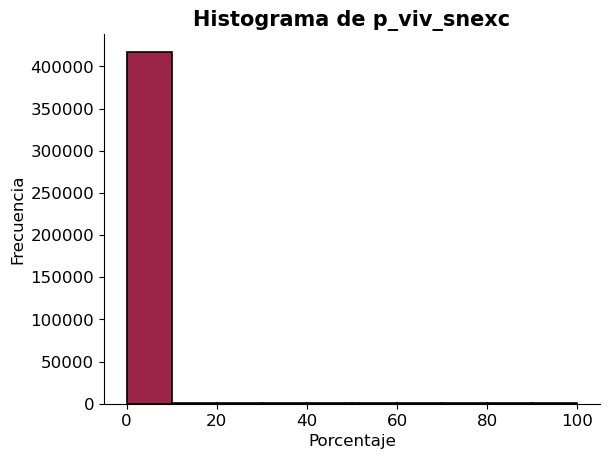

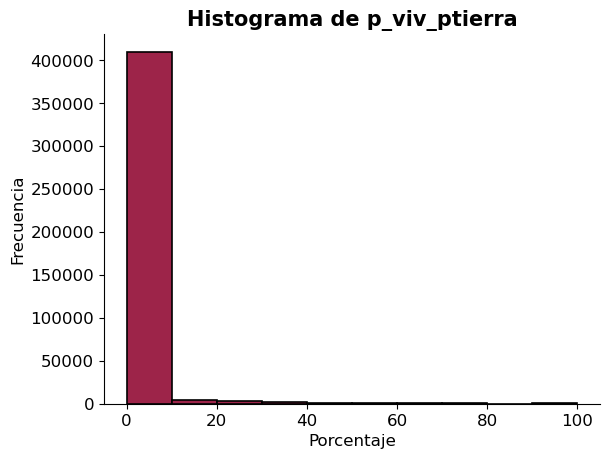

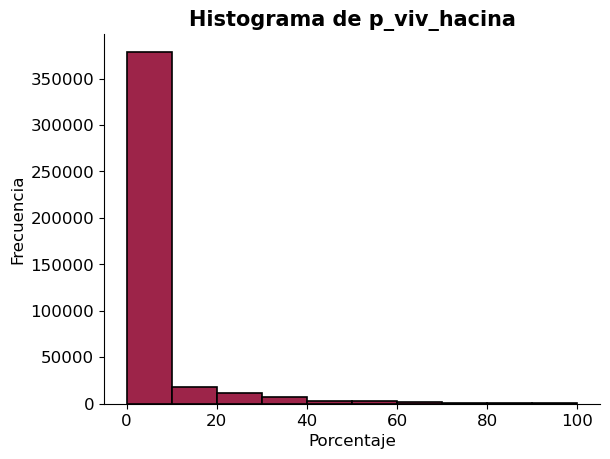

In [14]:
#Histograma de los indicadores
plt.rcParams.update({'font.size': 12})
for indicador in ['p_viv_snexc','p_viv_ptierra','p_viv_hacina']:
    plt.hist(df_limpia[indicador],bins=10,color='#9d2449',edgecolor='black', linewidth=1.2)
    plt.title("Histograma de "+indicador,fontsize=15,fontweight='bold')
    #Evitar que eje y tenga notación científica
    plt.ticklabel_format(style='plain', axis='y')
    plt.xlabel("Porcentaje")
    plt.ylabel("Frecuencia")
    #Eliminar bordes
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    plt.show()

In [15]:
#Suma de viviendas con pisos de tierra, sin excusado y en hacinamiento
print("El número de viviendas con pisos de tierra es "+str("{:,}".format(df_limpia['vph_pisoti'].sum())))
print("El número de viviendas sin excusado es "+str("{:,}".format(df_limpia['vph_letr'].sum())))
print("El número de viviendas en hacinamiento es "+str("{:,}".format(df_limpia['vph_1cuart'].sum()+df_limpia['vph_2cuart'].sum())))
#Total de viviendas particulares habitadas
print("El número de viviendas particulares habitadas es "+str("{:,}".format(df_limpia['tvivparhab'].sum())))

El número de viviendas con pisos de tierra es 91,137.0
El número de viviendas sin excusado es 43,447.0
El número de viviendas en hacinamiento es 1,406,407.0
El número de viviendas particulares habitadas es 9,403,191.0


## Cálculo de componentes principales para crear índice

In [16]:
dato_pca=df_limpia[['p_viv_snexc','p_viv_ptierra','p_viv_hacina']]
#Crear objeto PCA
pca = PCA(n_components=3)
#Entrenar PCA
data=pca.fit_transform(dato_pca)

[0.55936369 0.2436976  0.19693871]


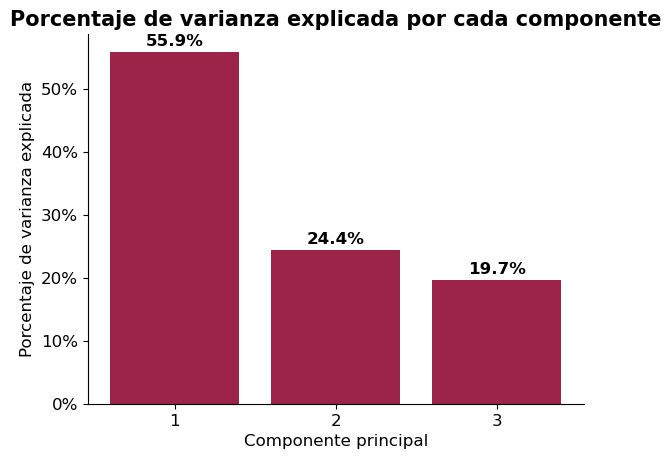

In [17]:
#Porcentaje de varianza explicada por cada componente
print(pca.explained_variance_ratio_)
#Gráfica de barras de varianza explicada
plt.bar(range(1,4),pca.explained_variance_ratio_,color='#9d2449',align='center')
plt.title('Porcentaje de varianza explicada por cada componente', fontsize=15, fontweight='bold')
plt.xlabel('Componente principal')
plt.ylabel('Porcentaje de varianza explicada')
plt.xticks(range(1,4))
#etiquetas en la parte superior de las barras
for x,y in zip(range(1,4),pca.explained_variance_ratio_):
    plt.text(x,y+0.01,str(round(y*100,1))+'%',color='black',ha='center',fontweight='bold')
    #Eje y multiplicado por 100
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#Eliminar borde derecho y superior
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()


In [18]:
#Suma de la varianza explicada por los componenntes 1 y 2   
print("La suma de la varianza explicada por los componentes 1 y 2 es "+str(round(pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1],3)))

La suma de la varianza explicada por los componentes 1 y 2 es 0.803


In [19]:
#Crear un índice de rezago habitacional con base en el primer y segundo componente principal
ind1=data[:,0]
ind2=data[:,1]
explained_variance=pca.explained_variance_ratio_
ind_rez=ind1*explained_variance[0]+ind2*explained_variance[1]
#Normalizar el índice de rezago habitacional
ind_rez=(ind_rez-ind_rez.min())/(ind_rez.max()-ind_rez.min())


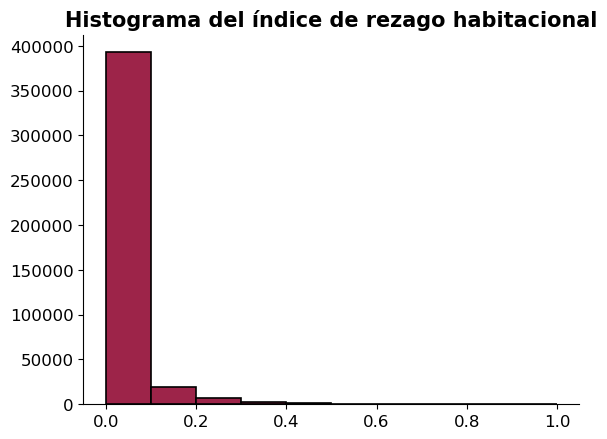

In [20]:
#Graficar el índice de rezago habitacional
plt.hist(ind_rez,bins=10,edgecolor='black', linewidth=1.2, color='#9d2449')
plt.title("Histograma del índice de rezago habitacional",fontsize=15, fontweight='bold')
#Evitar que eje y tenga notación científica
plt.ticklabel_format(style='plain', axis='y')
#Eliminar borde derecho y superior
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

In [21]:
#Agregar el índice de rezago habitacional al dataframe
df_limpia['ind_rez']=ind_rez

In [22]:
df_limpia

,cvegeo,entidad,nom_ent,mun,nom_mun,loc,nom_loc,ageb,mza,vivtot,...,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sinltc,vph_sincint,vph_sintic,p_viv_snexc,p_viv_ptierra,p_viv_hacina,ind_rez
4,0100100010017001,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,1,82,...,5.0,5.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,1.465934e-13
5,0100100010017002,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,2,83,...,0.0,5.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,2.595787e-13
6,0100100010017003,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,3,84,...,5.0,5.0,4.0,0.0,35.0,0.0,0.0,0.0,0.0,0.000000e+00
7,0100100010017004,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,4,84,...,9.0,5.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,6.382121e-16
8,0100100010017005,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,5,68,...,5.0,6.0,0.0,3.0,22.0,0.0,0.0,0.0,0.0,6.382121e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58926,1208100010054001,12,Guerrero,81,Iliatenco,1,Iliatenco,0054,1,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.382121e-16
58927,1208100010054002,12,Guerrero,81,Iliatenco,1,Iliatenco,0054,2,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.382121e-16
58928,1208100010054800,12,Guerrero,81,Iliatenco,1,Iliatenco,0054,800,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.382121e-16
58930,1208100010069001,12,Guerrero,81,Iliatenco,1,Iliatenco,0069,1,29,...,0.0,0.0,5.0,11.0,16.0,3.0,0.0,0.0,0.0,6.382121e-16


In [23]:
#Obtener 30 primeros registros con mayor rezago habitacional. Mostrar entidad, nom_ent, mun, nom_mun, lc, nom_loc, ind_rez
df_limpia.sort_values(by='ind_rez',ascending=False).head(60)[['entidad','nom_ent','mun','nom_mun','loc','nom_loc','p_viv_snexc','p_viv_ptierra','p_viv_hacina','ind_rez']]

,entidad,nom_ent,mun,nom_mun,loc,nom_loc,p_viv_snexc,p_viv_ptierra,p_viv_hacina,ind_rez
27533,12,Guerrero,29,Chilpancingo de los Bravo,1,Chilpancingo de los Bravo,100.000000,100.000000,100.000000,1.000000
3454,3,Baja California Sur,2,Mulegé,482,Villa Alberto Andrés Alvarado Arámburo,100.000000,100.000000,100.000000,1.000000
34712,7,Chiapas,89,Tapachula,1,Tapachula de Córdova y Ordóñez,100.000000,100.000000,100.000000,1.000000
27529,12,Guerrero,29,Chilpancingo de los Bravo,1,Chilpancingo de los Bravo,100.000000,100.000000,100.000000,1.000000
34715,7,Chiapas,89,Tapachula,1,Tapachula de Córdova y Ordóñez,100.000000,100.000000,100.000000,1.000000
34713,7,Chiapas,89,Tapachula,1,Tapachula de Córdova y Ordóñez,88.461538,100.000000,100.000000,0.968131
55777,2,Baja California,6,San Quintín,121,Ejido Papalote,100.000000,80.000000,100.000000,0.946372
56149,2,Baja California,6,San Quintín,248,Emiliano Zapata,100.000000,75.000000,100.000000,0.932965
47376,2,Baja California,4,Tijuana,1,Tijuana,100.000000,100.000000,80.000000,0.908868
56487,2,Baja California,6,San Quintín,585,Lázaro Cárdenas,100.000000,60.000000,100.000000,0.892744


In [24]:
#Obtener 30 primeros registros con mayor rezago habitacional. Mostrar entidad, nom_ent, mun, nom_mun, lc, nom_loc, ind_rez
df_limpia[(df_limpia['entidad']==20)].sort_values(by='ind_rez',ascending=False).head(30)[['entidad','nom_ent','mun','nom_mun','loc','nom_loc','p_viv_snexc','p_viv_ptierra','p_viv_hacina','ind_rez']]

,entidad,nom_ent,mun,nom_mun,loc,nom_loc,p_viv_snexc,p_viv_ptierra,p_viv_hacina,ind_rez


In [25]:
#Contar número de registros de Aguascalientes
df_limpia[(df_limpia['entidad']==1)].shape[0]

13448

In [26]:
#Realizar clasificación de rezago de muy alto, alto, medio, bajo y muy bajo
df_limpia['rezago_c']=pd.cut(df_limpia['ind_rez'],bins=[-1,0.2,0.4,0.6,0.8,1],labels=['muy bajo','bajo','medio','alto','muy alto'])

In [27]:
#Ordenar de mayor a menor rezago
df_limpia=df_limpia.sort_values(by='ind_rez',ascending=False)
df_limpia

,cvegeo,entidad,nom_ent,mun,nom_mun,loc,nom_loc,ageb,mza,vivtot,...,vph_cvj,vph_sinrtv,vph_sinltc,vph_sincint,vph_sintic,p_viv_snexc,p_viv_ptierra,p_viv_hacina,ind_rez,rezago_c
27533,1202900010158005,12,Guerrero,29,Chilpancingo de los Bravo,1,Chilpancingo de los Bravo,0158,5,6,...,0.0,4.0,0.0,5.0,0.0,100.0,100.0,100.0,1.000000e+00,muy alto
3454,0300204820028045,3,Baja California Sur,2,Mulegé,482,Villa Alberto Andrés Alvarado Arámburo,0028,45,5,...,0.0,3.0,0.0,3.0,0.0,100.0,100.0,100.0,1.000000e+00,muy alto
34712,070890001169A044,7,Chiapas,89,Tapachula,1,Tapachula de Córdova y Ordóñez,169A,44,13,...,0.0,0.0,0.0,13.0,0.0,100.0,100.0,100.0,1.000000e+00,muy alto
27529,1202900010158001,12,Guerrero,29,Chilpancingo de los Bravo,1,Chilpancingo de los Bravo,0158,1,7,...,0.0,0.0,0.0,4.0,0.0,100.0,100.0,100.0,1.000000e+00,muy alto
34715,070890001169A047,7,Chiapas,89,Tapachula,1,Tapachula de Córdova y Ordóñez,169A,47,19,...,0.0,0.0,0.0,17.0,0.0,100.0,100.0,100.0,1.000000e+00,muy alto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11543,0702700450557042,7,Chiapas,27,Chiapa de Corzo,45,Julián Grajales,0557,42,8,...,0.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,6.382121e-16,muy bajo
11541,0702700450557040,7,Chiapas,27,Chiapa de Corzo,45,Julián Grajales,0557,40,14,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,6.382121e-16,muy bajo
11540,0702700450557039,7,Chiapas,27,Chiapa de Corzo,45,Julián Grajales,0557,39,10,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,6.382121e-16,muy bajo
58931,1208100010069002,12,Guerrero,81,Iliatenco,1,Iliatenco,0069,2,8,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,6.382121e-16,muy bajo


In [28]:
#Guardar en csv
#df_limpia.to_csv('df_limpia.csv',index=False,columns=['cvegeo','entidad','nom_ent','mun','nom_mun','loc','nom_loc','mza','p_viv_snexc','p_viv_ptierra','p_viv_hacina','ind_rez','rezago_c'])

In [29]:
#filtrar df_limpia para el estado de Guerrero
df_guerrero=df_limpia[df_limpia['entidad']==12]

In [30]:
df_guerrero["cvegeo"].info()

<class 'pandas.core.series.Series'>
Index: 41973 entries, 27533 to 58931
Series name: cvegeo
Non-Null Count  Dtype 
--------------  ----- 
41973 non-null  object
dtypes: object(1)
memory usage: 655.8+ KB


### Procesamiento de datos geográficos e imágenes satelitales

In [31]:
descarga_manzanas=[{"url": "https://www.inegi.org.mx/contenidos/productos/prod_serv/contenidos/espanol/bvinegi/productos/geografia/marcogeo/889463807469/12_guerrero.zip",
                        "filename": "12_guerrero.zip",
                        "check_file_path": "datos/conjunto_de_datos/12m.shp",
                        "extract_path": "datos"}]
for file in descarga_manzanas:
    download_and_extract(file["url"], file["filename"], file["check_file_path"], file["extract_path"])

El archivo 12_guerrero.zip existe, no se descargará.


In [32]:
#leer shape de manzanas
manzanas=gpd.read_file("datos/conjunto_de_datos/12m.shp")
#Convertir crs a wgs84
manzanas = manzanas.to_crs(epsg=4326)
manzanas.columns=[i.lower() for i in manzanas.columns]
manzanas=pd.merge(manzanas,df_guerrero,how="left",on="cvegeo")
#Eliminar nans
manzanas=manzanas[manzanas['ind_rez'].notna()]
#Filtrar para municipio de Acapulco
manzanas=manzanas[manzanas['cve_mun']=='001']
#Cambiar tipo de datos de rezago_c de categoría a string
manzanas['rezago_c']=manzanas['rezago_c'].astype(str)
#Crear una variable klass con el valor de rezago_c. Tiene que ser un entero de 1 a 5
manzanas['klass']=manzanas['rezago_c'].replace({'muy bajo':1,'bajo':2,'medio':3,'alto':4,'muy alto':5})
manzanas

,cvegeo,cve_ent,cve_mun,cve_loc,cve_ageb,cve_mza,ambito,tipomza,geometry,entidad,...,vph_sinrtv,vph_sinltc,vph_sincint,vph_sintic,p_viv_snexc,p_viv_ptierra,p_viv_hacina,ind_rez,rezago_c,klass
0,1200100013912070,12,001,0001,3912,070,Urbana,Típica,"POLYGON ((-99.83317 16.91776, -99.83328 16.917...",12.0,...,0.0,0.0,5.0,0.0,0.0,0.000000,0.000000,6.382121e-16,muy bajo,1
1,1200100010496015,12,001,0001,0496,015,Urbana,Típica,"POLYGON ((-99.91418 16.83146, -99.91413 16.831...",12.0,...,6.0,10.0,58.0,0.0,0.0,3.225806,12.258065,6.450487e-02,muy bajo,1
4,1200100016419036,12,001,0001,6419,036,Urbana,Típica,"POLYGON ((-99.80175 16.82337, -99.80181 16.823...",12.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,6.382121e-16,muy bajo,1
5,1200100016739041,12,001,0001,6739,041,Urbana,Típica,"POLYGON ((-99.79775 16.83788, -99.79853 16.837...",12.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,6.382121e-16,muy bajo,1
6,1200100016739014,12,001,0001,6739,014,Urbana,Típica,"POLYGON ((-99.79973 16.83869, -99.79972 16.838...",12.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,6.382121e-16,muy bajo,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19661,1200100013132044,12,001,0001,3132,044,Urbana,Típica,"POLYGON ((-99.95237 16.89784, -99.95239 16.897...",12.0,...,0.0,0.0,7.0,0.0,0.0,0.000000,0.000000,6.382121e-16,muy bajo,1
19662,1200100013132003,12,001,0001,3132,003,Urbana,Típica,"POLYGON ((-99.95349 16.89762, -99.95347 16.897...",12.0,...,0.0,0.0,4.0,0.0,0.0,0.000000,0.000000,6.382121e-16,muy bajo,1
19663,1200100014906025,12,001,0001,4906,025,Urbana,Típica,"POLYGON ((-99.81672 16.81413, -99.81672 16.814...",12.0,...,0.0,0.0,5.0,0.0,0.0,0.000000,0.000000,6.382121e-16,muy bajo,1
19664,1200100010477030,12,001,0001,0477,030,Urbana,Típica,"POLYGON ((-99.84340 16.85410, -99.84333 16.854...",12.0,...,3.0,4.0,19.0,3.0,0.0,0.000000,11.320755,5.158423e-02,muy bajo,1


In [33]:
manzanas["klass"].unique()

array([1, 2, 3, 4, 5], dtype=int64)

In [95]:
url="https://www.inegi.org.mx/contenido/productos/prod_serv/contenidos/espanol/bvinegi/productos/geografia/imagen_terri/geomediana_landsat/gm_2020_MX_016013_t.zip"
filename="gm_2020-01-01-2020_11_30_MX_016013.tif"
check_file_path="datos/MX_016013"
extract_path="datos"
download_and_extract(url, filename, check_file_path, extract_path)

El archivo gm_2020-01-01-2020_11_30_MX_016013.tif no existe. Descargando.


Proyección: PROJCS["Albers",GEOGCS["GCS_GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",12],PARAMETER["longitude_of_center",-102],PARAMETER["standard_parallel_1",17.5],PARAMETER["standard_parallel_2",29.5],PARAMETER["false_easting",2500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


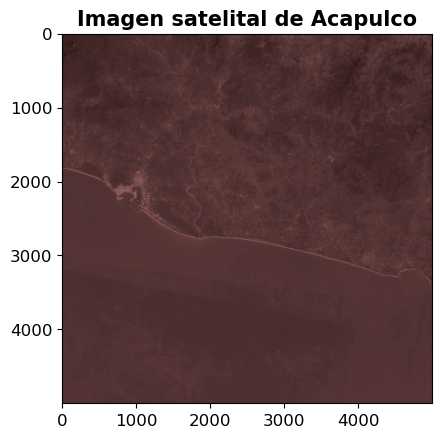

In [96]:
image_path="datos/MX_016013/gm_2020-01-01-2020_11_30_MX_016013.tif"
#Leer imagen y mostrar
img = rasterio.open(image_path)
print("Proyección:",img.crs)
plt.title("Imagen satelital de Acapulco",fontsize=15,fontweight='bold')
plt.imshow(img.read(1), cmap='pink')


In [89]:
# Convertir los límites de la imagen a una geometría de tipo 'box'
bounds = img.bounds
bbox = box(bounds.left, bounds.bottom, bounds.right, bounds.top)
#Obtener límites de la imagen
print("Límites de la imagen:",bbox.bounds)

Límites de la imagen: (2700000.0, 450000.0, 2850000.0, 600000.0)


In [90]:
#tomar la proyección de la imagen
#Crear un geodataframe con la geometría de manzanas y la proyección de la imagen
manzanas_gdf=gpd.GeoDataFrame(manzanas,geometry='geometry')
manzanas_gdf.crs = 'EPSG:4326'
#Reproyectar manzanas a la proyección de la imagen
manzanas_gdf=manzanas_gdf.to_crs(crs=img.crs)
print("Proyección:",manzanas_gdf.crs)
print(len(manzanas_gdf))
print("Reprojected geometries bounds:", manzanas_gdf.total_bounds)
manzanas_gdf

Proyección: PROJCS["Albers",GEOGCS["GCS_GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",12],PARAMETER["longitude_of_center",-102],PARAMETER["standard_parallel_1",17.5],PARAMETER["standard_parallel_2",29.5],PARAMETER["false_easting",2500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
12798
Reprojected geometries bounds: [2712804.49647979  521959.26583161 2749564.98971497  563853.72269223]


,cvegeo,cve_ent,cve_mun,cve_loc,cve_ageb,cve_mza,ambito,tipomza,geometry,entidad,...,vph_sinrtv,vph_sinltc,vph_sincint,vph_sintic,p_viv_snexc,p_viv_ptierra,p_viv_hacina,ind_rez,rezago_c,klass
0,1200100013912070,12,001,0001,3912,070,Urbana,Típica,"POLYGON ((2731073.304 542181.489, 2731062.403 ...",12.0,...,0.0,0.0,5.0,0.0,0.0,0.000000,0.000000,6.382121e-16,muy bajo,1
1,1200100010496015,12,001,0001,0496,015,Urbana,Típica,"POLYGON ((2722572.933 532515.282, 2722578.510 ...",12.0,...,6.0,10.0,58.0,0.0,0.0,3.225806,12.258065,6.450487e-02,muy bajo,1
4,1200100016419036,12,001,0001,6419,036,Urbana,Típica,"POLYGON ((2734582.609 531798.813, 2734575.872 ...",12.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,6.382121e-16,muy bajo,1
5,1200100016739041,12,001,0001,6739,041,Urbana,Típica,"POLYGON ((2734984.689 533409.114, 2734902.009 ...",12.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,6.382121e-16,muy bajo,1
6,1200100016739014,12,001,0001,6739,014,Urbana,Típica,"POLYGON ((2734772.860 533495.372, 2734773.606 ...",12.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,6.382121e-16,muy bajo,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19661,1200100013132044,12,001,0001,3132,044,Urbana,Típica,"POLYGON ((2718393.837 539794.038, 2718391.956 ...",12.0,...,0.0,0.0,7.0,0.0,0.0,0.000000,0.000000,6.382121e-16,muy bajo,1
19662,1200100013132003,12,001,0001,3132,003,Urbana,Típica,"POLYGON ((2718274.699 539767.551, 2718276.621 ...",12.0,...,0.0,0.0,4.0,0.0,0.0,0.000000,0.000000,6.382121e-16,muy bajo,1
19663,1200100014906025,12,001,0001,4906,025,Urbana,Típica,"POLYGON ((2733000.165 530753.483, 2733000.415 ...",12.0,...,0.0,0.0,5.0,0.0,0.0,0.000000,0.000000,6.382121e-16,muy bajo,1
19664,1200100010477030,12,001,0001,0477,030,Urbana,Típica,"POLYGON ((2730088.129 535128.645, 2730094.947 ...",12.0,...,3.0,4.0,19.0,3.0,0.0,0.000000,11.320755,5.158423e-02,muy bajo,1


In [58]:
# Asegúrate de que 'manzanas_gdf' tiene una columna 'klass'
shapes = [(geom, value) for geom, value in zip(manzanas_gdf.geometry, manzanas_gdf['klass'])]

# Usa los datos de la imagen satelital que ya cargaste
out_shape = (img.height, img.width)
transform = img.transform

# Rasterizar las manzanas con los valores de 'klass'
rasterized_klass = rasterize(shapes, out_shape=out_shape, fill=0, transform=transform)
unique_values_in_raster = np.unique(rasterized_klass)
print(unique_values_in_raster)
#Obtener si las manzanas tienen la misma proyección que la imagen
print(manzanas_gdf.crs==img.crs)

[0 1 2 3 4 5]
True


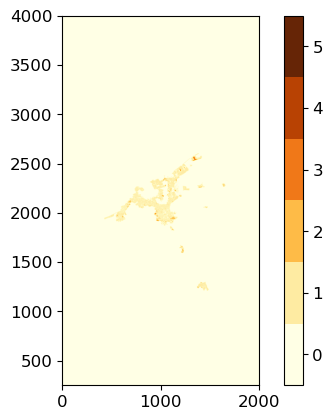

In [81]:

# Assuming rasterized_klass is the array obtained from rasterizing the geometries
plt.imshow(rasterized_klass, cmap='YlOrBr')
plt.xlim(0, 2000)
plt.ylim(250, 4000)
#Colorbar cortado por categorías
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))

In [76]:
#Guardar raster en tif
with rasterio.open('rasterized_klass.tif', 'w', driver='GTiff', height=rasterized_klass.shape[0],
                   width=rasterized_klass.shape[1], count=1, dtype=rasterized_klass.dtype,
                   crs=img.crs, transform=img.transform) as dst:
    dst.write(rasterized_klass, 1)

In [73]:
image_copy = img.read(1)

In [82]:
# Asumiendo que tienes:
# 'image_data' es la matriz de datos de la imagen (por ejemplo, una banda de la imagen)
# 'rasterized_klass' es la matriz de la misma forma que 'image_data' con los valores de 'klass'

# Aplanar las matrices
image_data_flat = image_copy.flatten()
rasterized_klass_flat = rasterized_klass.flatten()

# Crear un DataFrame con los datos aplanados
df_raster= pd.DataFrame({
    'pixel_val': image_data_flat,
    'klass_val': rasterized_klass_flat
})

# Ahora 'df' es un DataFrame donde cada fila corresponde a un píxel en tus datos rasterizados

# Si necesitas las coordenadas de cada píxel, puedes hacer lo siguiente:
# Obtener las coordenadas de cada píxel en la imagen
rows, cols = np.indices(out_shape)
coords = (rows.flatten(), cols.flatten())

# Transformar coordenadas de píxeles a coordenadas del sistema de referencia espacial
coords_transformed = rasterio.transform.xy(transform, *coords, offset='center')

# Añadir las coordenadas al DataFrame
df_raster['x_coord'] = coords_transformed[0]
df_raster['y_coord'] = coords_transformed[1]

#Crear variables con coordenadas en wgs84
df_raster['lon']=df_raster['x_coord']
df_raster['lat']=df_raster['y_coord']

#Crear variables con coordenadas en wgs84
df_raster['lon']=df_raster['x_coord']
df_raster['lat']=df_raster['y_coord']

#transformar coordenadas a wgs84
df_raster['lon'],df_raster['lat']=rasterio.warp.transform(img.crs, 'EPSG:4326', df_raster['lon'], df_raster['lat'])

# Ahora 'df' incluye columnas para los valores de los píxeles, los valores de 'klass' y sus coordenadas

In [83]:
df_raster

,pixel_val,klass_val,x_coord,y_coord,lon,lat
0,467,0,2700015.0,599985.0,-100.117313,17.444246
1,478,0,2700045.0,599985.0,-100.117031,17.444243
2,512,0,2700075.0,599985.0,-100.116749,17.444239
3,581,0,2700105.0,599985.0,-100.116466,17.444236
4,567,0,2700135.0,599985.0,-100.116184,17.444232
...,...,...,...,...,...,...
24999995,406,0,2849865.0,450015.0,-98.739054,16.063263
24999996,402,0,2849895.0,450015.0,-98.738775,16.063257
24999997,403,0,2849925.0,450015.0,-98.738495,16.063251
24999998,404,0,2849955.0,450015.0,-98.738216,16.063245
